# Preprocessing audio samples
In order to perform keyword spotting we need to train our network to recognise specific words. In this notebook, the preprocessing of audio samples is explored, which helps the network to learn the difference between audio samples more quickly.

## Import libraries

In [38]:
from IPython.display import HTML, Audio
from ipywebrtc import AudioRecorder, CameraStream
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa

## Get audio sample
Run the code cell below to display the audio widget. If this doesn't display you will need to run `jupyter nbextension enable --py widgetsnbextension` and restart the notebook. Click the dot to begin recording and click again once finished. 

_Adapted from: https://medium.com/@harrycblum/record-audio-in-a-jupyter-notebook-da08a88278bb_

In [39]:
stream = CameraStream(constraints={'audio': True, 'video': False})
recorder = AudioRecorder(stream=stream)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Convert recorded audio to .wav format from webm and save this in a numpy array. This function outputs the numpy array and the sameple rate that has been used to record the audio.

In [40]:
process = (ffmpeg
           .input('pipe:0')
           .output('pipe:1', format='wav')
           .run_async(pipe_stdin=True, 
                      pipe_stdout=True, 
                      pipe_stderr=True, 
                      quiet=True, 
                      overwrite_output=True)
          )

output, err = process.communicate(input=recorder.audio.value)

riff_chunk_size = len(output) - 8
q = riff_chunk_size
b = []
for i in range(4):
    q, r = divmod(q, 256)
    b.append(r)
riff = output[:4] + bytes(b) + output[8:]
sr, audio = wav_read(io.BytesIO(riff))
print(audio, sr)

[  0   0   0 ... 247 279 321] 48000


## Visualize the sample
First we display the sample as an unaltered signal.

(-28343.0, 28343.0)

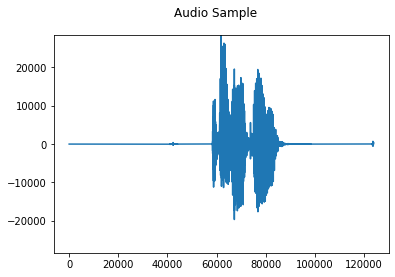

In [41]:
max_val = max(audio)
plt.plot(audio)
plt.suptitle('Audio Sample')
plt.ylim(-max_val, max_val)

Now display the Fast Fourier Transform (FFT) of the sample. The FFT allows us to see the audio sample from the frequency domain.

Text(0, 0.5, 'Amplitude')

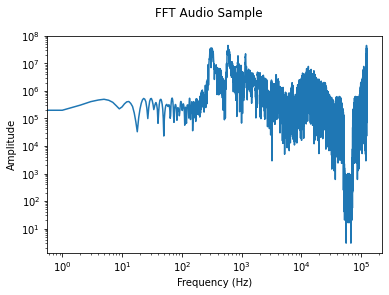

In [42]:
audio_fft = np.abs(2*np.fft.fft(audio))
plt.plot(audio_fft)
plt.xscale('log')
plt.yscale('log')
plt.suptitle('FFT Audio Sample')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

Now display the audio sample as a spectrogram. This allows the difference between audio samples to be seen easily by eye. Therefore, convolutional neural networks can learn faster. 

Text(0.5, 0.98, 'Spectrogram of Audio Sample')

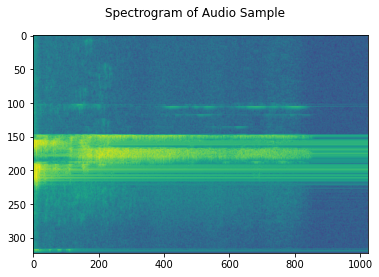

In [43]:
spectrogram = tfio.audio.spectrogram(audio/1.0, 
                                     nfft=2048, 
                                     window=len(audio), 
                                     stride=int(sr * 0.008))

plt.imshow(tf.math.log(spectrogram).numpy(), aspect='auto')
plt.suptitle('Spectrogram of Audio Sample')

An improvement over the spectrogram is the Mel Scale. This helps to associate features more similarly to human hearing.

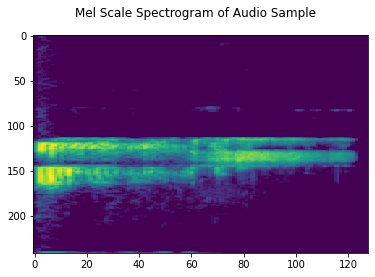

In [44]:
melspectrogram = librosa.feature.melspectrogram(np.float32(audio), 
                                                sr=sr, 
                                                n_fft=2048, 
                                                hop_length=512, 
                                                n_mels=128)
mfcc = librosa.power_to_db(melspectrogram, ref=np.max)

plt.imshow(np.swapaxes(mfcc, 0, 1), 
           interpolation='nearest', 
           cmap=cm.viridis, 
           origin='lower', 
           aspect='auto')
plt.suptitle('Mel Scale Spectrogram of Audio Sample')
plt.gca().invert_yaxis()